In [654]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers

In [619]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [620]:
# Paths
train_path = r'D:\Projects\Software_Engineering\Artificial_Intelligence\Cellula_Internship\Computer_Vision\Datasets\Teeth_Dataset\Training'
test_path = r'D:\Projects\Software_Engineering\Artificial_Intelligence\Cellula_Internship\Computer_Vision\Datasets\Teeth_Dataset\Testing'
validation_path = r'D:\Projects\Software_Engineering\Artificial_Intelligence\Cellula_Internship\Computer_Vision\Datasets\Teeth_Dataset\Validation'
augmented_path = r'D:\Projects\Software_Engineering\Artificial_Intelligence\Cellula_Internship\Computer_Vision\Datasets\Teeth_Dataset\Augmented'

In [621]:
# ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.3,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [622]:
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

val_gen = val_datagen.flow_from_directory(
    validation_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [623]:
def plot_images_per_class(generator, num_images_per_class=3):
    
    class_indices = generator.class_indices
    class_labels = list(class_indices.keys())

    plt.figure(figsize=(15, len(class_labels) * 5))

    for i, class_label in enumerate(class_labels):
        # Filter images for the current class
        class_images = [image for image, label in zip(generator.filenames, generator.classes) if label == class_indices[class_label]]

        # Select a sample of images
        sample_images = np.random.choice(class_images, num_images_per_class, replace=False)

        for j, img_path in enumerate(sample_images):
            img = plt.imread(os.path.join(generator.directory, img_path))
            plt.subplot(len(class_labels), num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 1:  # Center image in each row
                plt.title(f'Class: {class_label}', fontsize=16)

    plt.tight_layout()
    plt.show()

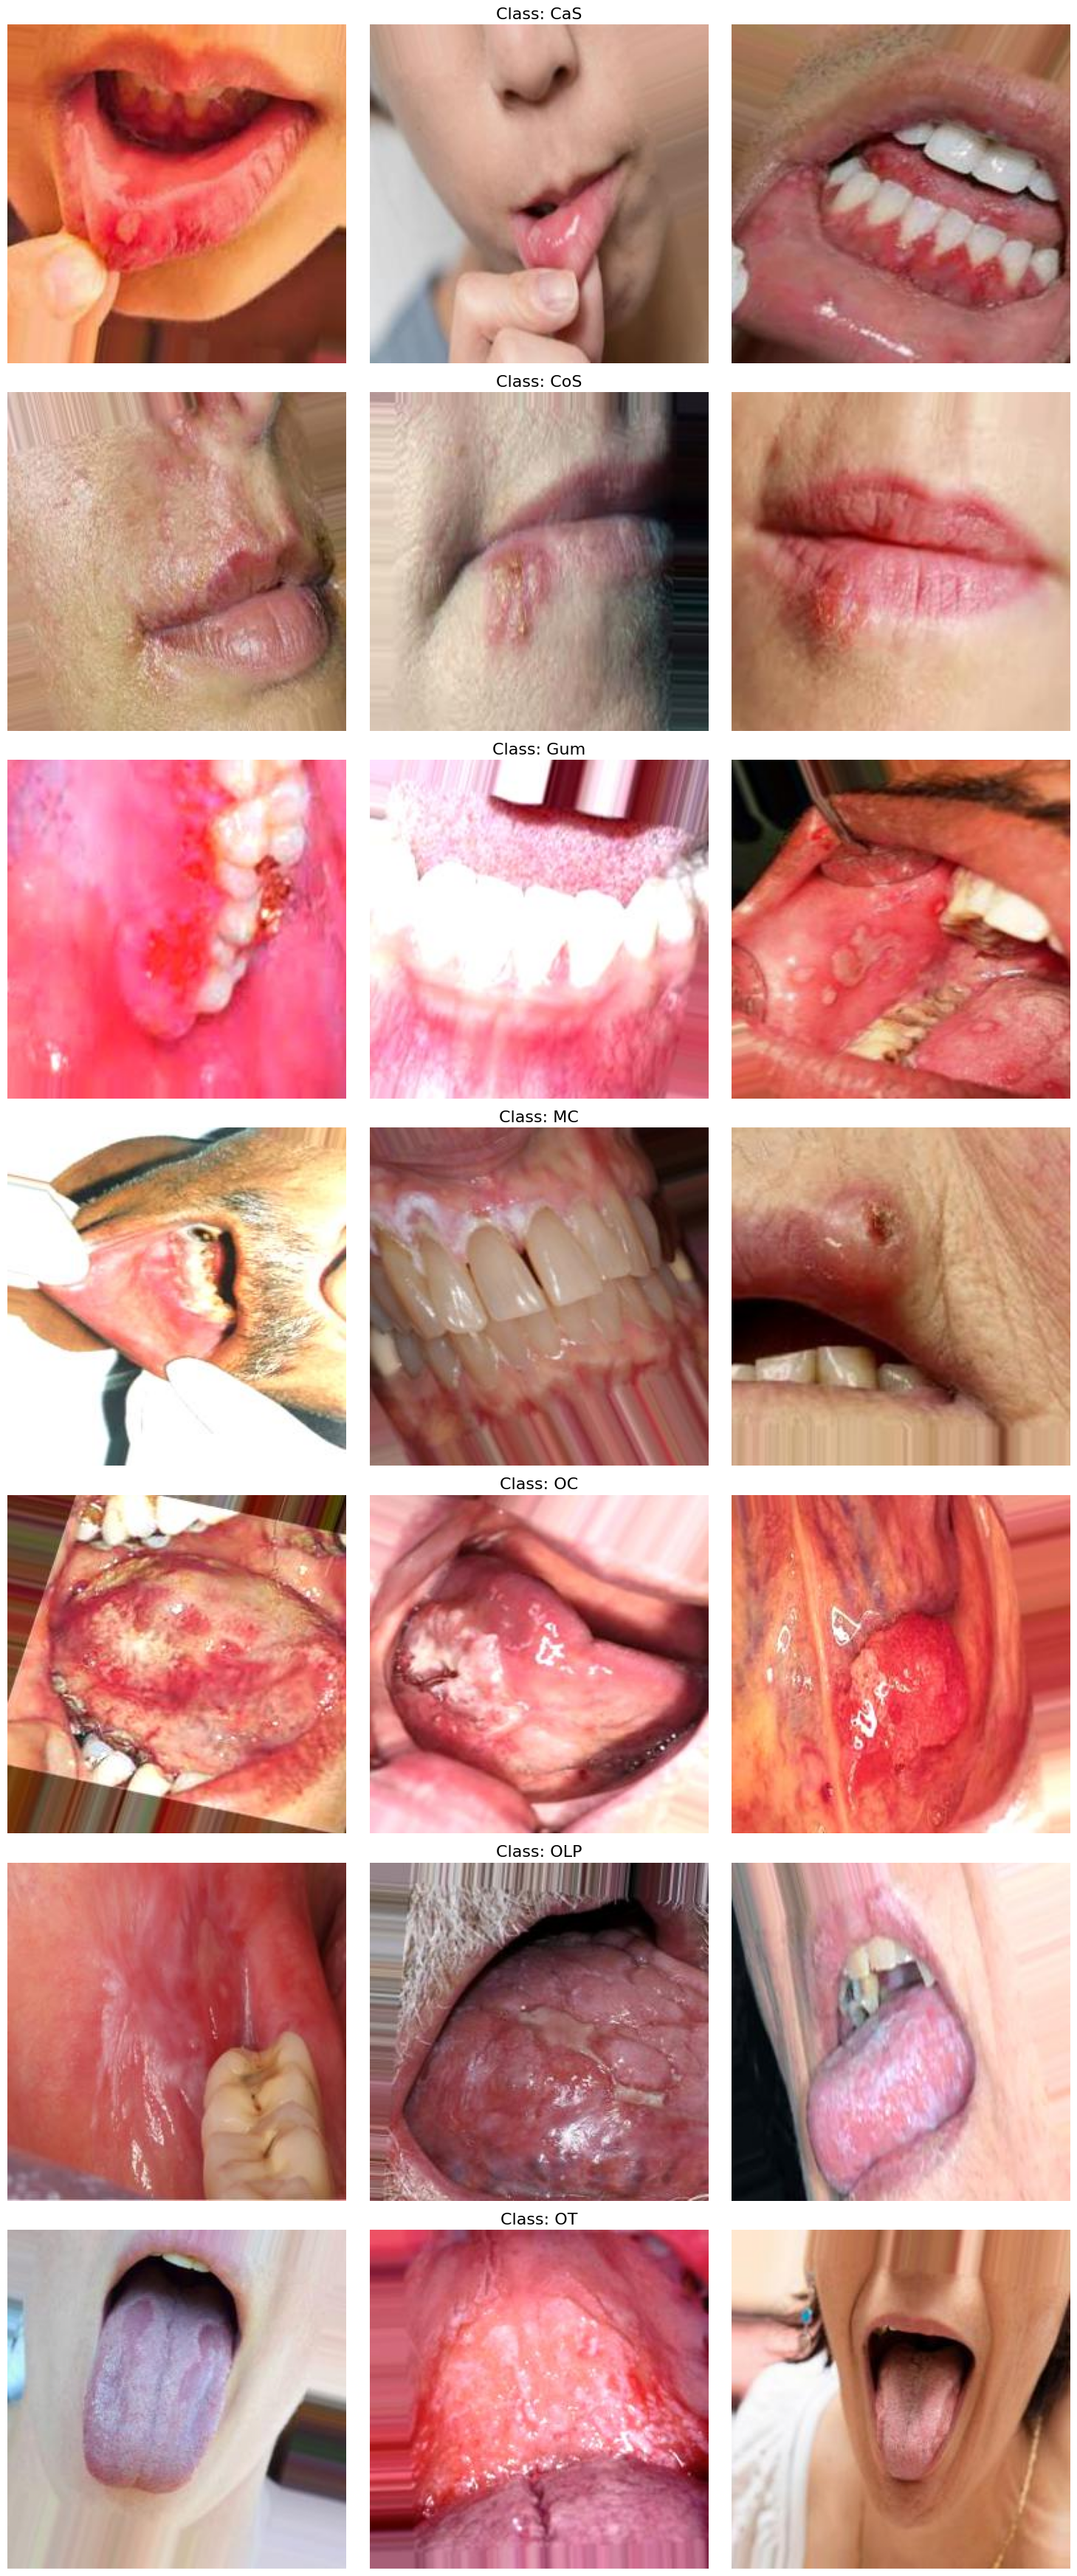

In [624]:
plot_images_per_class(train_gen)

In [625]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [626]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [631]:
# Updated Model Architecture
model = models.Sequential([    
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add Dropout for regularization
    layers.Dense(len(train_gen.class_indices), activation='softmax')
])

# Compile Model with a different optimizer
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_458 (Conv2D)             │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_456               │ (None, 127, 127, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_459 (Conv2D)             │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_457               │ (None, 62, 62, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_460 (Conv2D)             │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_458               │ (None, 30, 30, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_461 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_459               │ (None, 14, 14, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_80 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,975 (25.99 MB)

 Trainable params: 6,811,975 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [628]:
# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,  # Adjusted patience
    min_lr=0.00001
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Adjusted patience for early stopping
    restore_best_weights=True
)

# Class weights to handle class imbalance
class_counts = np.unique(train_gen.classes, return_counts=True)[1]
total = np.sum(class_counts)
class_weight = {
    i: total / (len(class_counts) * count)
    for i, count in enumerate(class_counts)
}

In [629]:
# Train the model
hist = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight
)

Epoch 1/50


c:\Users\EngSherifMostafa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


193/193 ━━━━━━━━━━━━━━━━━━━━ 107s 539ms/step - accuracy: 0.1770 - loss: 1.9192 - val_accuracy: 0.2549 - val_loss: 1.8101 - learning_rate: 1.0000e-04
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 105s 537ms/step - accuracy: 0.2546 - loss: 1.8321 - val_accuracy: 0.3064 - val_loss: 1.7285 - learning_rate: 1.0000e-04
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 106s 545ms/step - accuracy: 0.2904 - loss: 1.7518 - val_accuracy: 0.3872 - val_loss: 1.5862 - learning_rate: 1.0000e-04
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 112s 573ms/step - accuracy: 0.3416 - loss: 1.6733 - val_accuracy: 0.4484 - val_loss: 1.4787 - learning_rate: 1.0000e-04
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 107s 546ms/step - accuracy: 0.3597 - loss: 1.5970 - val_accuracy: 0.3667 - val_loss: 1.5860 - learning_rate: 1.0000e-04
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 112s 572ms/step - accuracy: 0.3537 - loss: 1.5850 - val_accuracy: 0.4173 - val_loss: 1.5226 - learning_rate: 1.0000e-04
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 110s 564ms/

In [630]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 1/65 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.8750 - loss: 0.5110

c:\Users\EngSherifMostafa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.7631 - loss: 0.7128
Test Loss: 0.7807548642158508
Test Accuracy: 0.7198443412780762


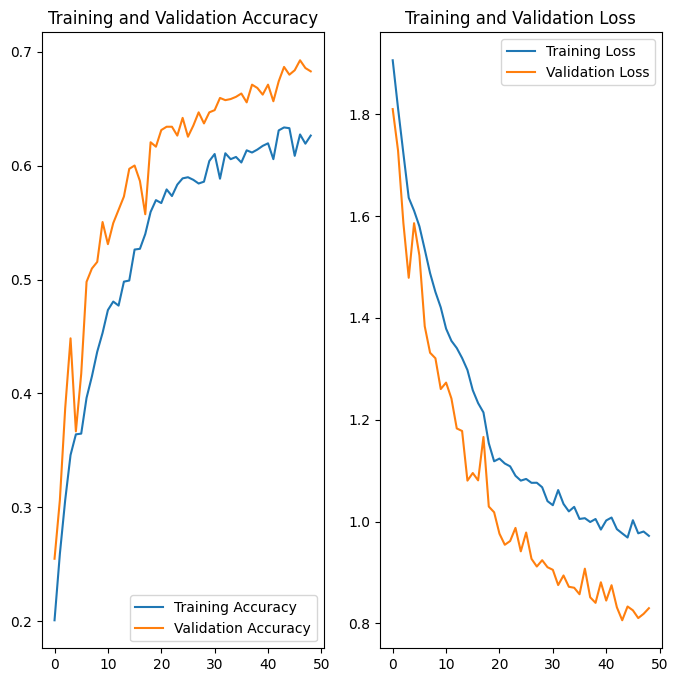

In [651]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(hist.history['accuracy'])), accuracy, label='Training Accuracy')
plt.plot(range(len(hist.history['val_accuracy'])), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(hist.history['loss'])), loss, label='Training Loss')
plt.plot(range(len(hist.history['val_loss'])), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step


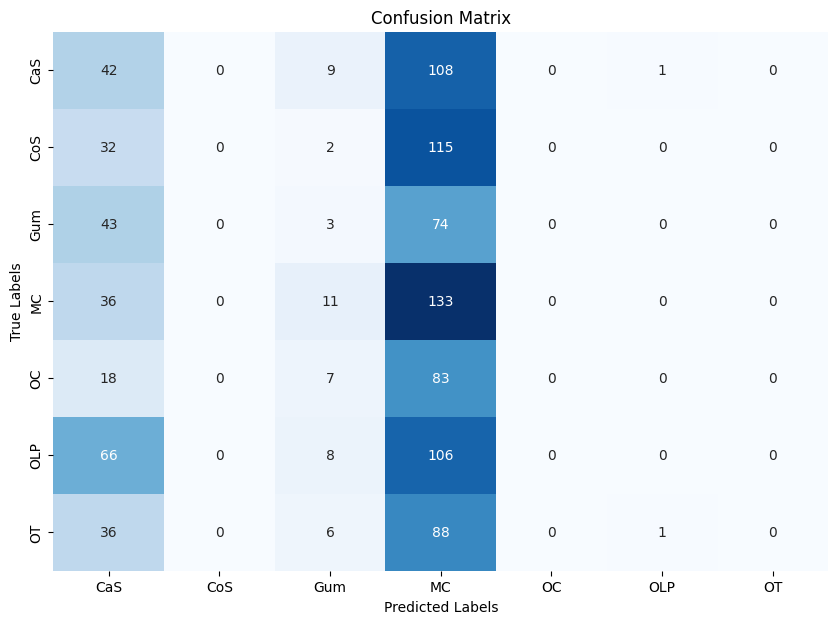

In [655]:
# Predict on test data
test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_gen.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert confusion matrix to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=[i for i in test_gen.class_indices], columns=[i for i in test_gen.class_indices])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=cm_df.columns, yticklabels=cm_df.index)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()